In [21]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


import h5py
#from read_raw import load_from_file
import maxlab_analysis as mla

import time
from scipy.signal import find_peaks
import scipy.stats as stats
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.cluster import KMeans, DBSCAN, OPTICS, SpectralClustering#, HDBSCAN

from umap import UMAP
import umap.plot


# Load Data

In [3]:
filestem = "batch2_20526div21"
filename = 'data/' + filestem + ".data.raw.h5"

In [4]:
Y = mla.load_spikes_from_file(filename, 0, 0, -10)
print(np.shape(Y))

bin_size = 0.02

mode = 'binary'
#mode = 'count'

X = mla.spike_array_from_file(filename, voltage_threshold=-10, mode = mode, bin_size = bin_size)
t = np.arange(0, np.shape(X)[0] * bin_size, bin_size)
print(np.shape(X))

print(X)
# for i, t in enumerate(time_points):
#     for channel in channel_list:
#         if X[i, channel] == 1:
#             plt.scatter(t, channel)

(71240, 3)
num spikes lost: 5814/71240=0.08161145423919147
(30001, 1024)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0.5, 0.98, 'batch2_20526div21, binary')

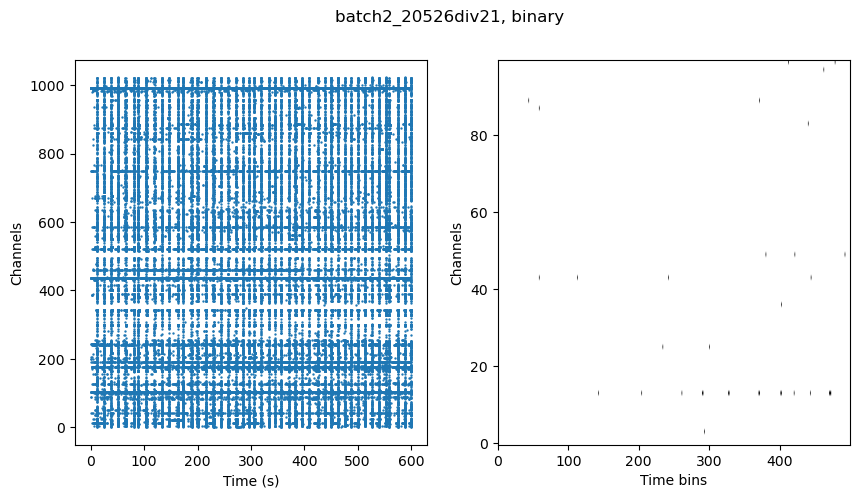

In [5]:


plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y['time'], Y['channel'], 0.5)
#plt.scatter(Y_synchronized['frameno'], Y_synchronized['channel'], 1, 'r')
#plt.xlim((0,10))
#plt.ylim((0, 100))
plt.xlabel('Time (s)')
plt.ylabel('Channels')
plt.subplot(1, 2, 2)


plt.imshow(X[:500, :100].transpose() * -1, aspect = 'auto', cmap = 'gray', origin = 'lower')
plt.xlabel('Time bins')
plt.ylabel('Channels')

plt.suptitle(filestem + ', ' + mode)

#plt.savefig(filestem + '_' + mode)

## Remove super active channels and inactive channels

[0.         0.01981601]
(30001, 1024)
(30001, 788)


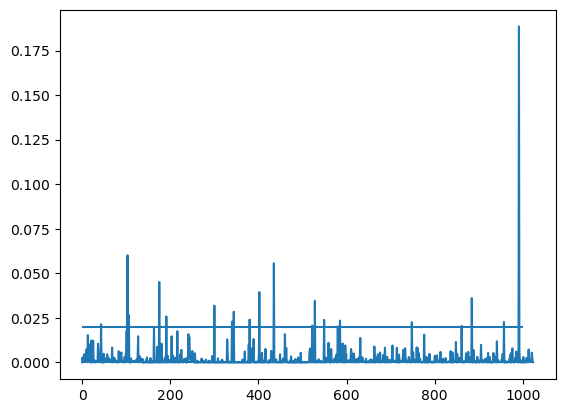

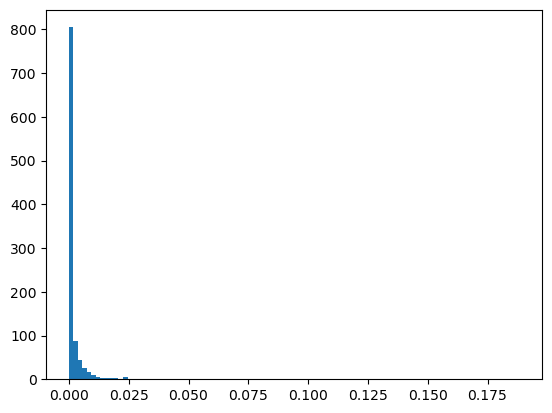

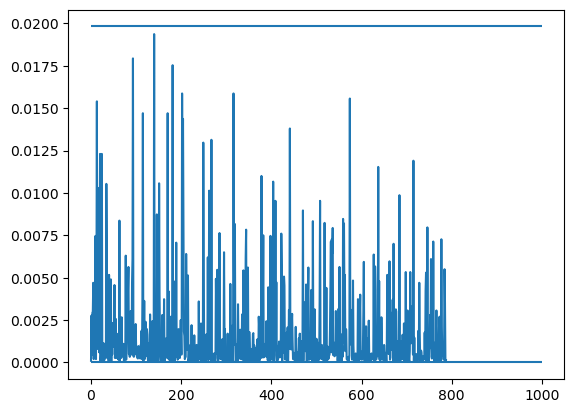

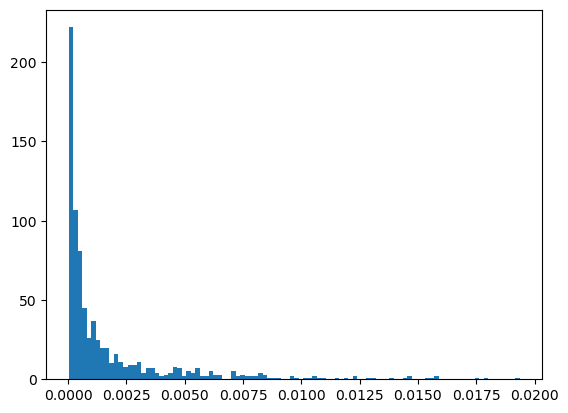

In [5]:
percentiles = [0, 98]
indices_to_delete = list()
fraction_bins_with_spikes_per_channel = np.mean(X[:], 0)

print(np.percentile(fraction_bins_with_spikes_per_channel, percentiles))


for channel in range(np.shape(X)[1]):
    if fraction_bins_with_spikes_per_channel[channel] >= np.percentile(fraction_bins_with_spikes_per_channel, percentiles[1]) or fraction_bins_with_spikes_per_channel[channel] <= np.percentile(fraction_bins_with_spikes_per_channel, percentiles[0]):
        indices_to_delete.append(channel)

X_trimmed = np.delete(X, indices_to_delete, 1)
fraction_bins_with_spikes_per_channel_trimmed = np.delete(fraction_bins_with_spikes_per_channel, indices_to_delete)


plt.plot(np.arange(np.shape(X)[1]), fraction_bins_with_spikes_per_channel)
plt.hlines(np.percentile(fraction_bins_with_spikes_per_channel, percentiles), 0, 1000)
plt.figure()
plt.hist(fraction_bins_with_spikes_per_channel, bins = 100)


plt.figure()
print(np.shape(X))

print(np.shape(X_trimmed))
plt.plot(np.arange(np.shape(X_trimmed)[1]), fraction_bins_with_spikes_per_channel_trimmed)
plt.hlines(np.percentile(fraction_bins_with_spikes_per_channel, percentiles), 0, 1000)
plt.figure()
plt.hist(fraction_bins_with_spikes_per_channel_trimmed, bins = 100)

plt.show()

## Remove inactive times

0.0
(30001, 1024)
(15836, 788)


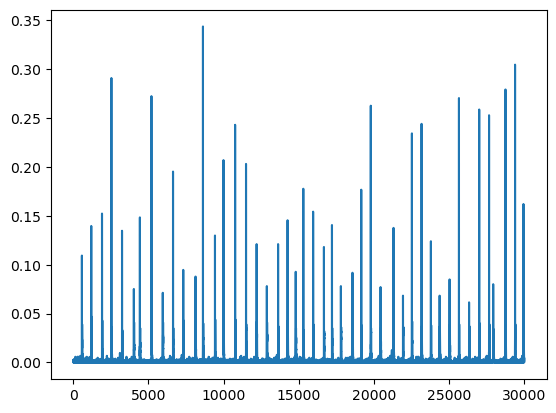

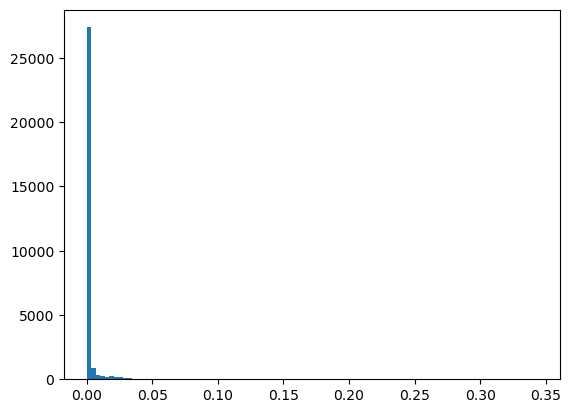

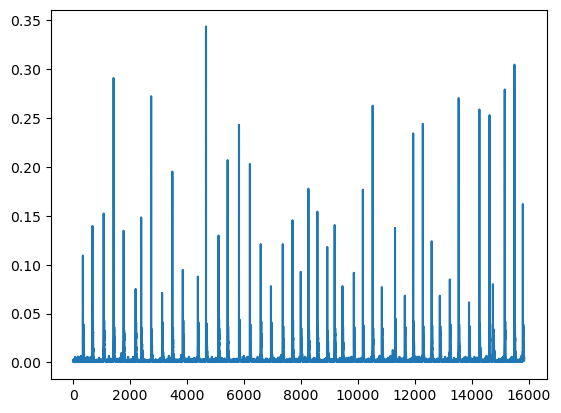

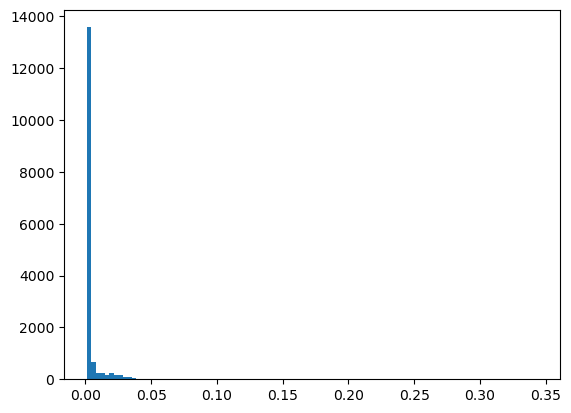

In [6]:
percentile = 10
indices_to_delete = list()

fraction_channels_with_spikes_per_bin = np.mean(X[:], 1)

print(np.percentile(fraction_channels_with_spikes_per_bin, percentile))

for bin in range(np.shape(X_trimmed)[0]):
    if fraction_channels_with_spikes_per_bin[bin] <= np.percentile(fraction_channels_with_spikes_per_bin, percentile):
        indices_to_delete.append(bin)

X_trimmed_both = np.delete(X_trimmed, indices_to_delete, 0)
fraction_channels_with_spikes_per_bin_trimmed = np.delete(fraction_channels_with_spikes_per_bin, indices_to_delete)


plt.plot(np.arange(np.shape(X)[0]), fraction_channels_with_spikes_per_bin)
plt.hlines(np.percentile(fraction_channels_with_spikes_per_bin, percentile), 0, 1000)
plt.figure()
plt.hist(fraction_channels_with_spikes_per_bin, bins = 100)


plt.figure()
print(np.shape(X))

print(np.shape(X_trimmed_both))
plt.plot(np.arange(np.shape(X_trimmed_both)[0]), fraction_channels_with_spikes_per_bin_trimmed)
plt.hlines(np.percentile(fraction_channels_with_spikes_per_bin, percentile), 0, 1000)
plt.figure()
plt.hist(fraction_channels_with_spikes_per_bin_trimmed, bins = 100)

plt.show()

# PCA

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
n_components = 6

pca = PCA(n_components)
X_pca = pca.fit_transform(X_trimmed_both)

print(pca.explained_variance_ratio_)

[0.12702641 0.04659489 0.0307896  0.02689545 0.0216806  0.0181874 ]


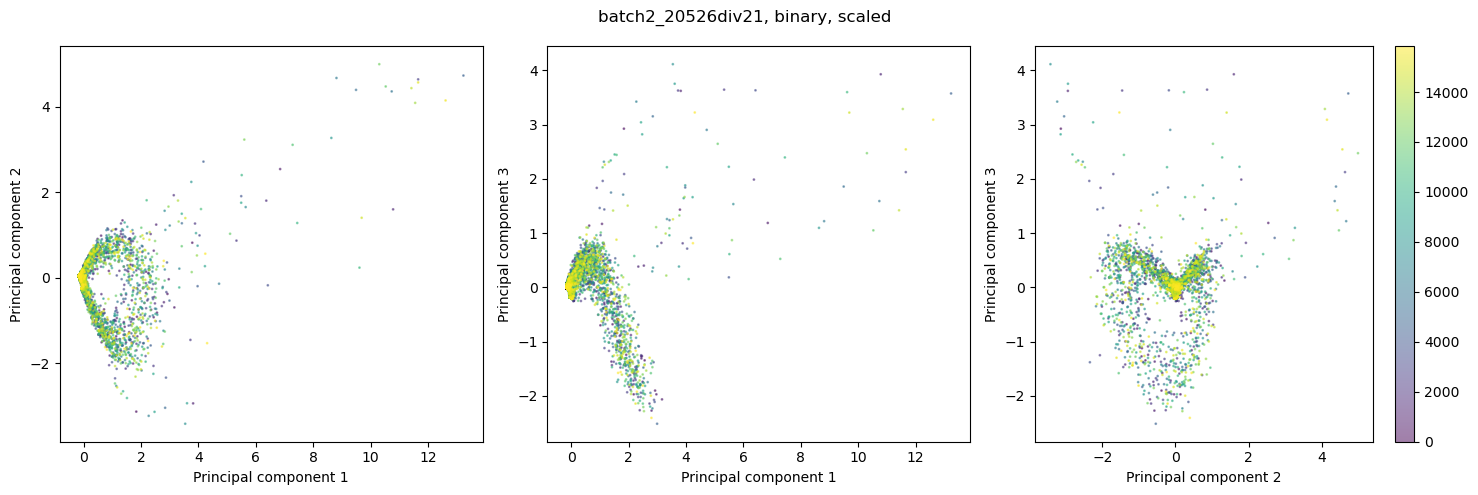

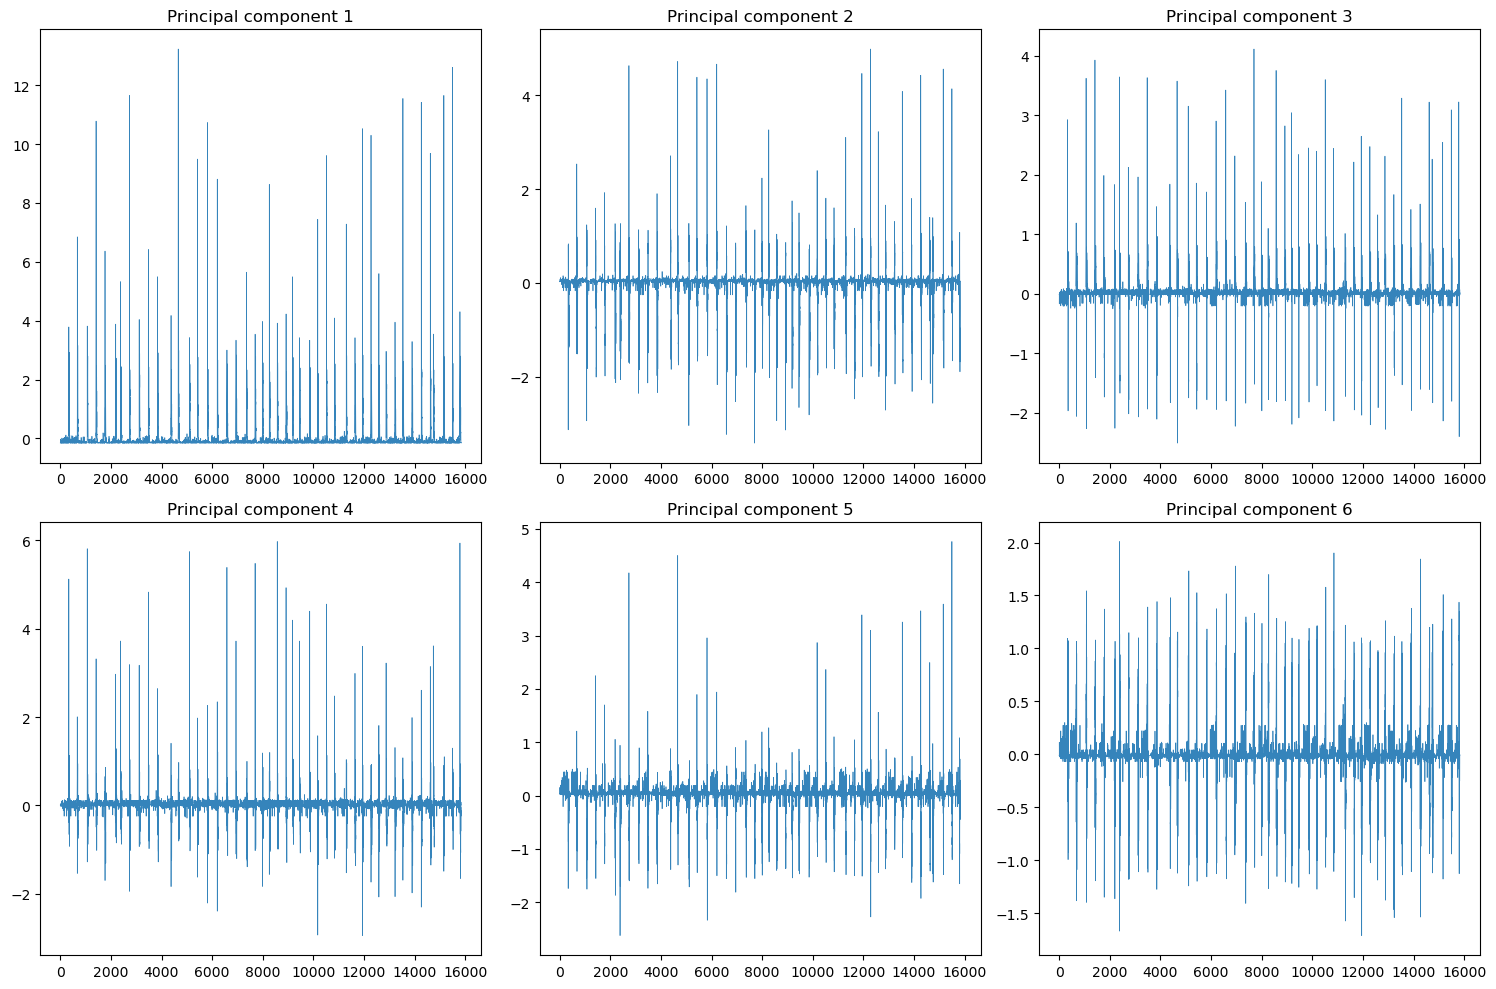

In [43]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_pca[:, 0], X_pca[:, 1],  s = 1, c = np.arange(np.shape(X_pca)[0]), alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.subplot(132)

plt.scatter(X_pca[:, 0], X_pca[:, 2],  s = 1, c = np.arange(np.shape(X_pca)[0]), alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 3')

plt.subplot(133)
plt.scatter(X_pca[:, 1], X_pca[:, 2],  s = 1, c = np.arange(np.shape(X_pca)[0]), alpha = 0.5)
plt.colorbar()
plt.xlabel('Principal component 2')
plt.ylabel('Principal component 3')

plt.suptitle(filestem + ', ' + mode + ', scaled')
#plt.savefig(filestem + '_' + mode + '_pca_scaled')


plt.tight_layout()

plt.show()

fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.plot(np.arange(np.shape(X_pca)[0]), X_pca[:, i-1], linewidth = 0.5, alpha = 0.9)
    plt.title('Principal component ' + str(i))
plt.tight_layout()
plt.show()

# Spectral embedding

In [17]:
X_se = list()
n_neighbors = [0.0005, 0.001, 0.0025, 0.005, 0.01, 0.02, 0.04]
#n_neighbors = [0.02]


for i, n in enumerate(n_neighbors):
    spectral_embedding = SpectralEmbedding(n_neighbors = int(n * np.shape(X)[0]))
    X_se.append(spectral_embedding.fit_transform(X_trimmed_both))

[0.0000e+00 2.0000e-02 4.0000e-02 ... 5.9996e+02 5.9998e+02 6.0000e+02]


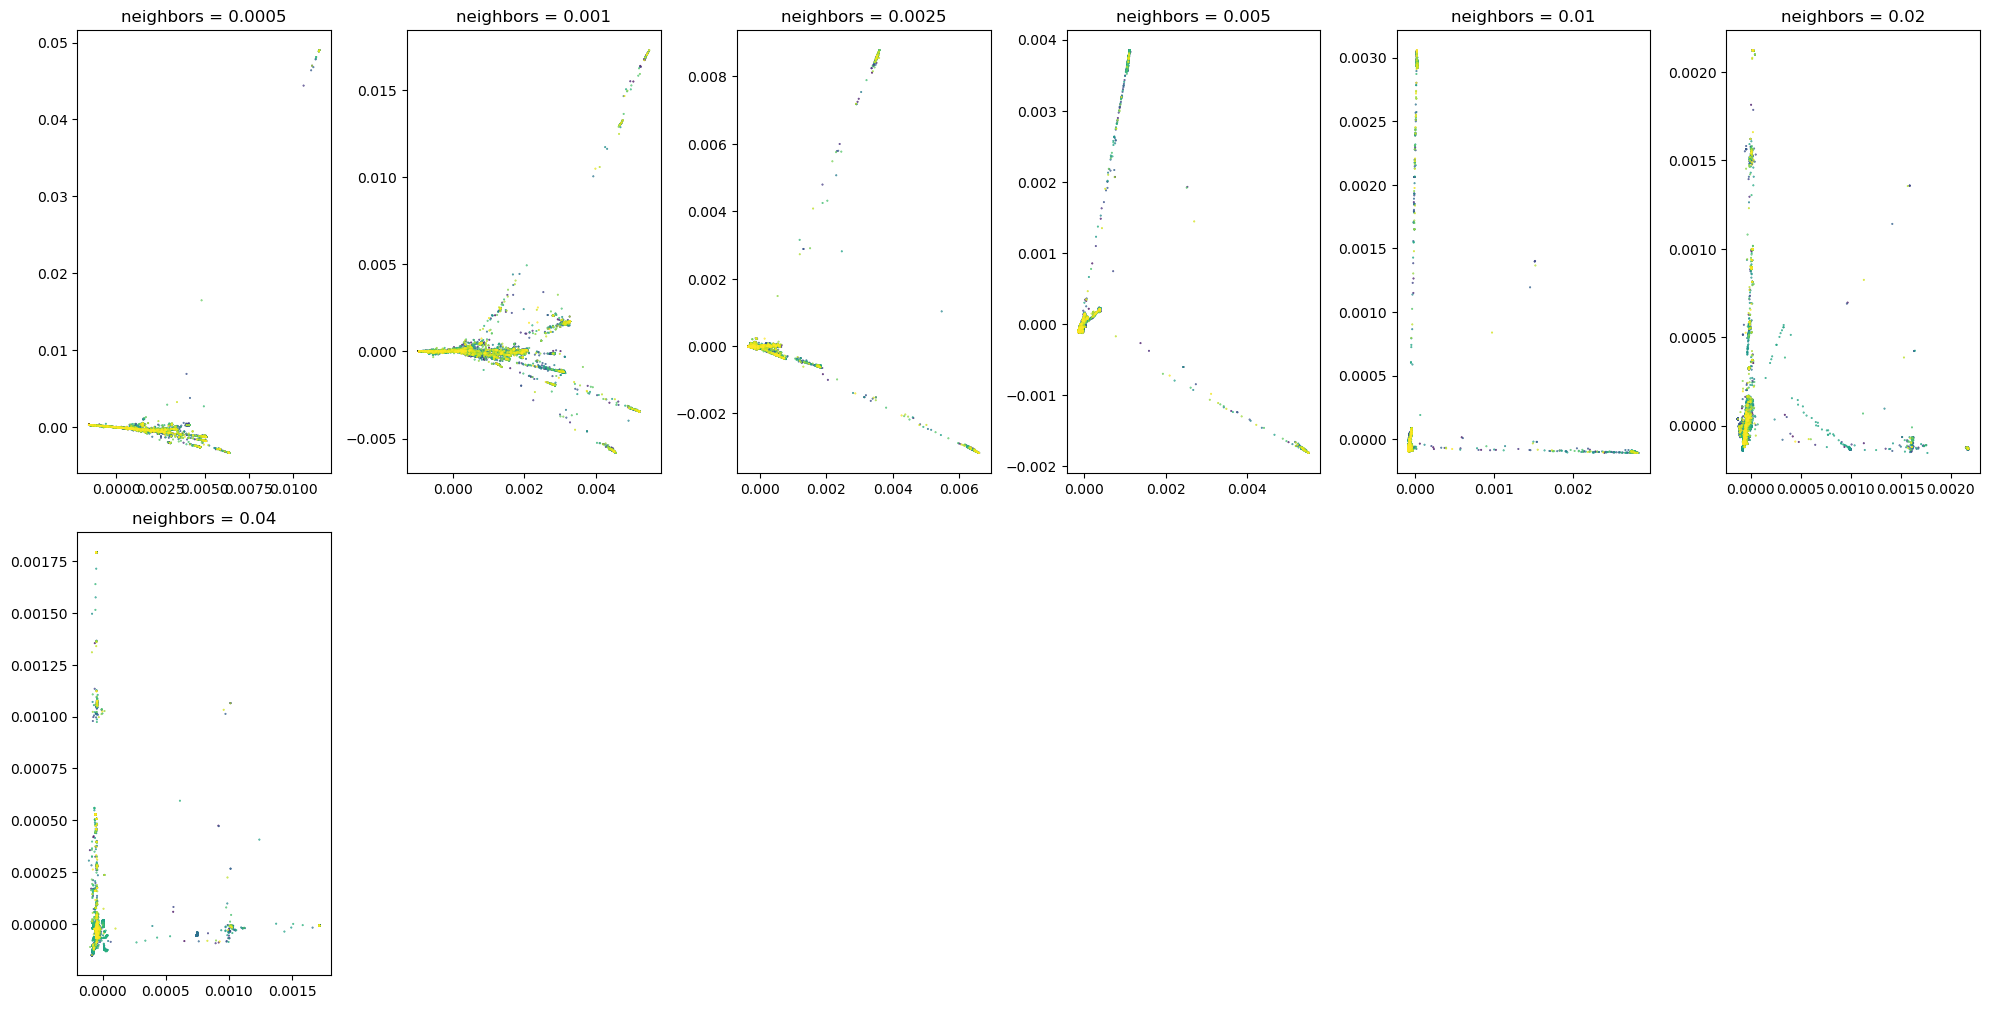

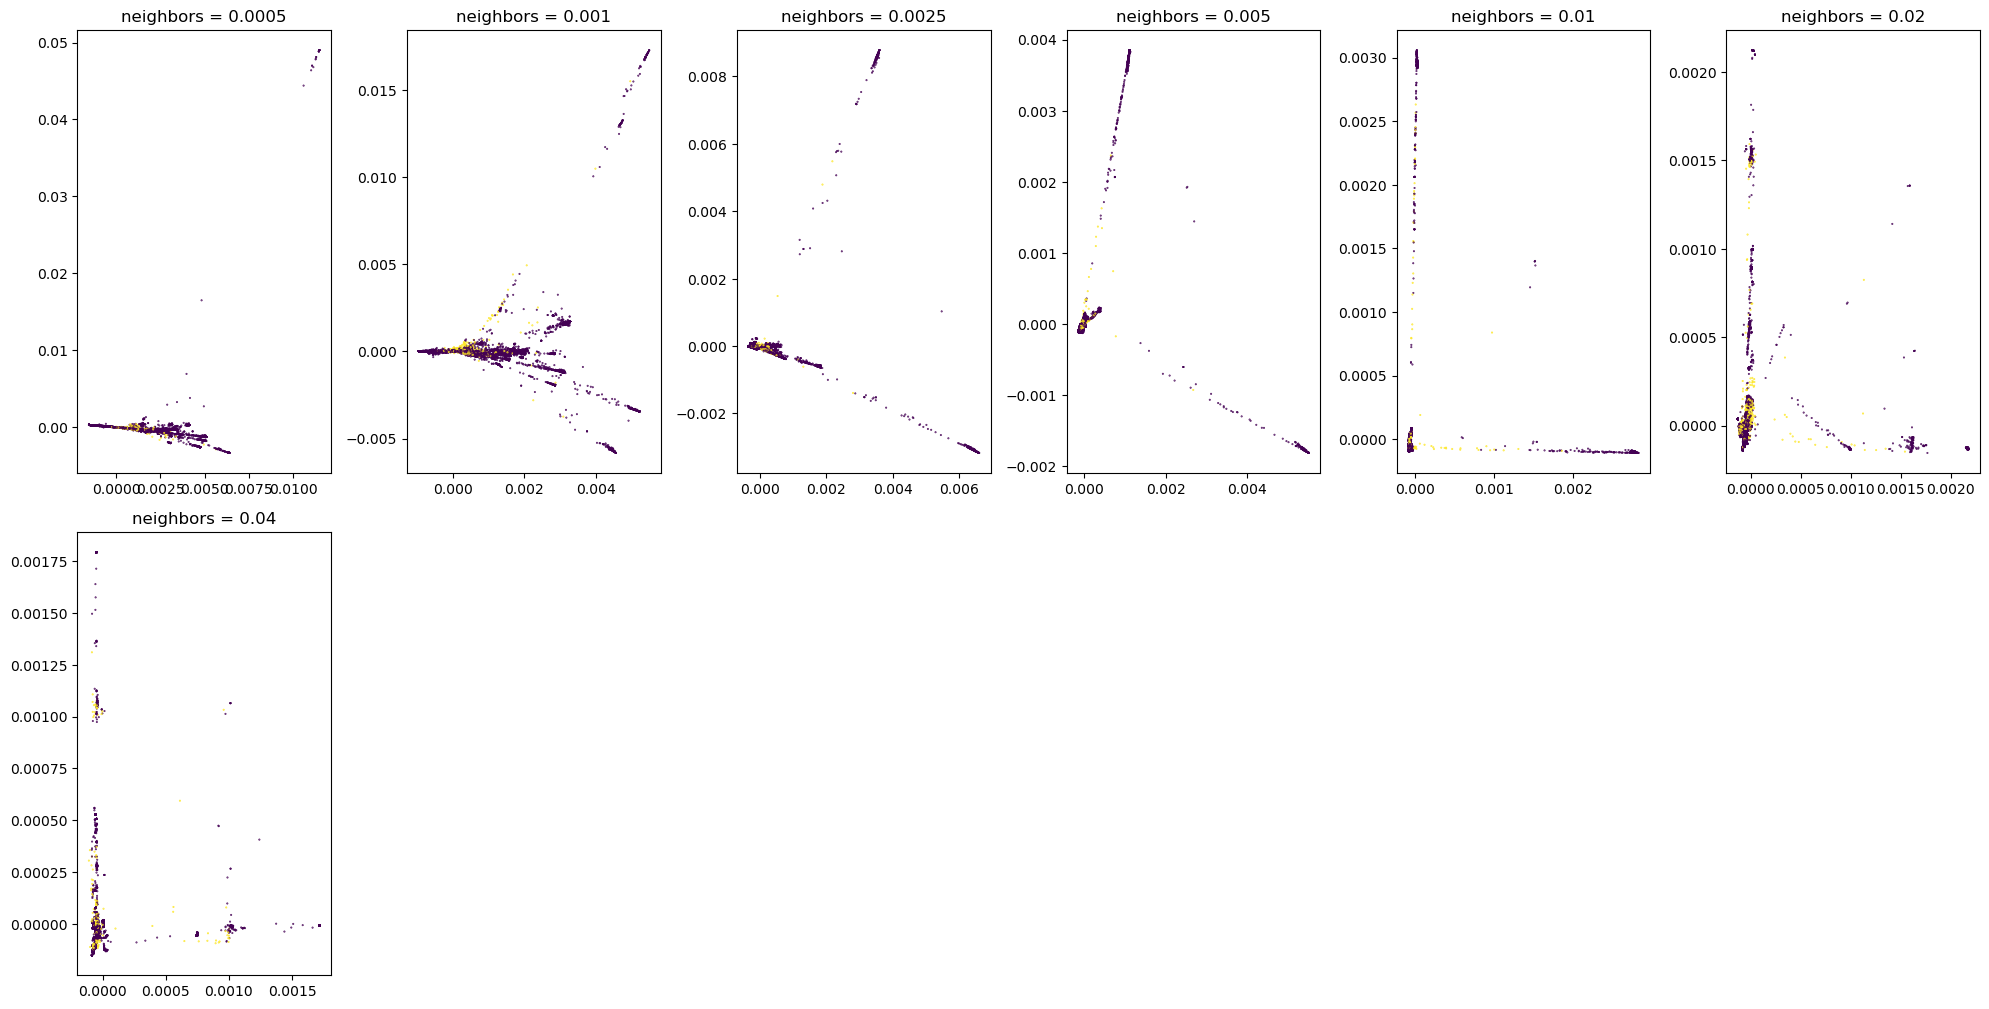

In [18]:
fig = plt.figure(figsize = (20, 20))
print(t)
for i, n in enumerate(n_neighbors):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_se[i][:, 0], X_se[i][:, 1], s = 0.2, c = np.arange(np.shape(X_se[i])[0]))
    plt.title('neighbors = ' + str(n))

plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (20, 20))
for i, n in enumerate(n_neighbors):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_se[i][:, 0], X_se[i][:, 1], s = 0.2, c = (X_pca[:, 0] > 1))
    plt.title('neighbors = ' + str(n))

plt.tight_layout()
plt.show()

# clustering

In [13]:

n_clusters = 5

X_se_clusters = list()
for i in range(0, len(X_se)):
    X_se_clusters.append(KMeans(n_clusters).fit_predict(X_se[i]))


c:\Users\nwu04\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nwu04\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nwu04\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nwu04\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


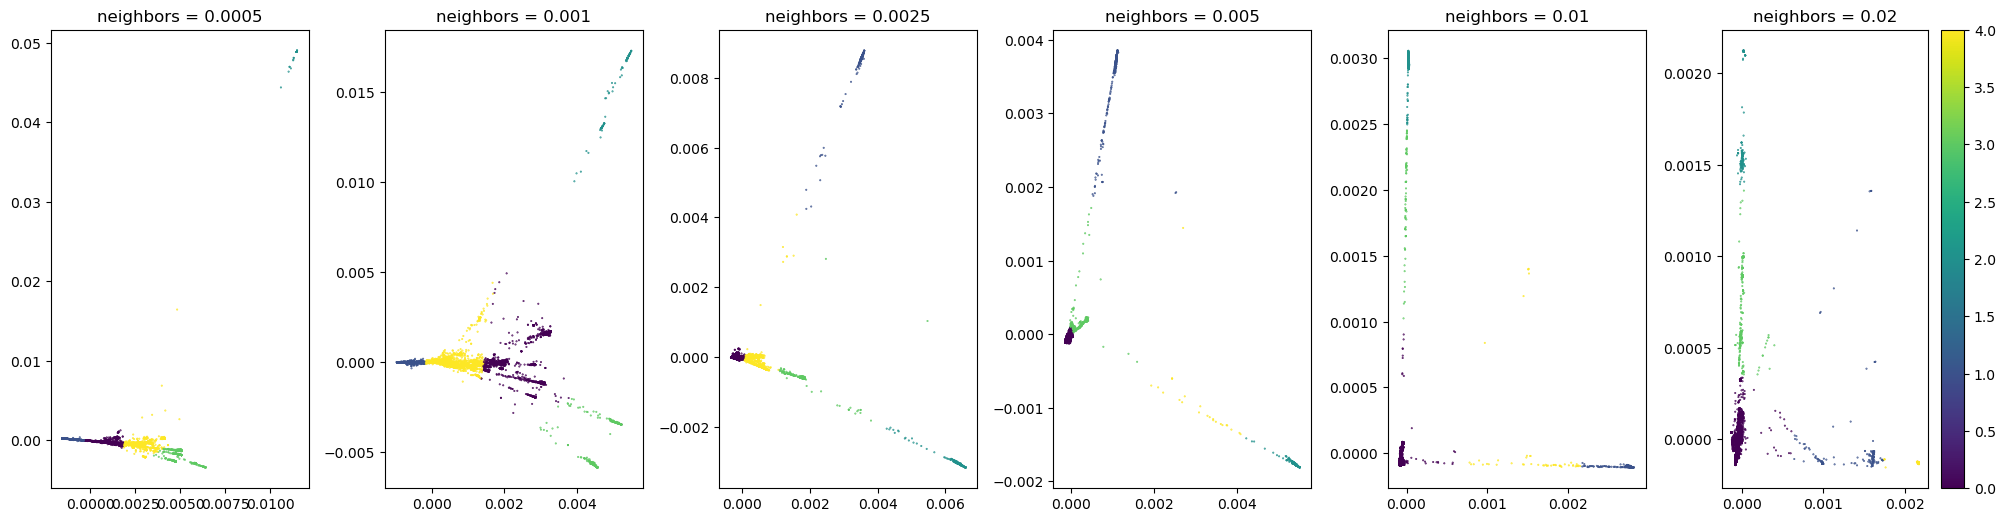

In [14]:
fig = plt.figure(figsize = (20, 20))
print(max(X_se_clusters[0]))

for i, n in enumerate(n_neighbors):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_se[i][:, 0], X_se[i][:, 1], s = 0.2, c = X_se_clusters[i])
    plt.title('neighbors = ' + str(n))

plt.tight_layout()
plt.colorbar()
plt.show()

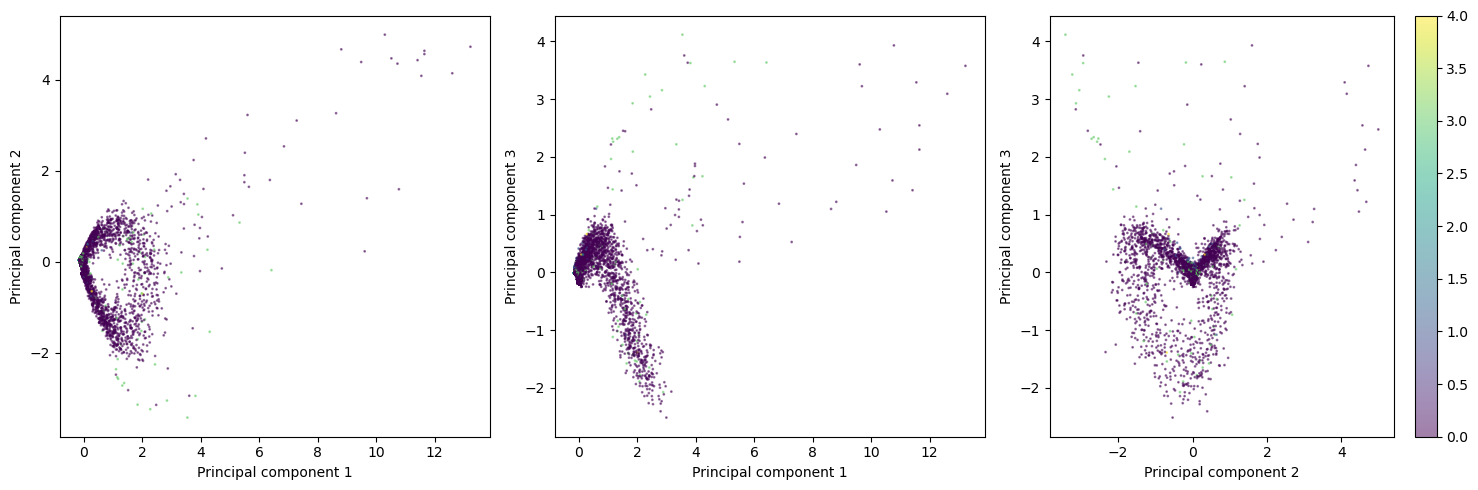

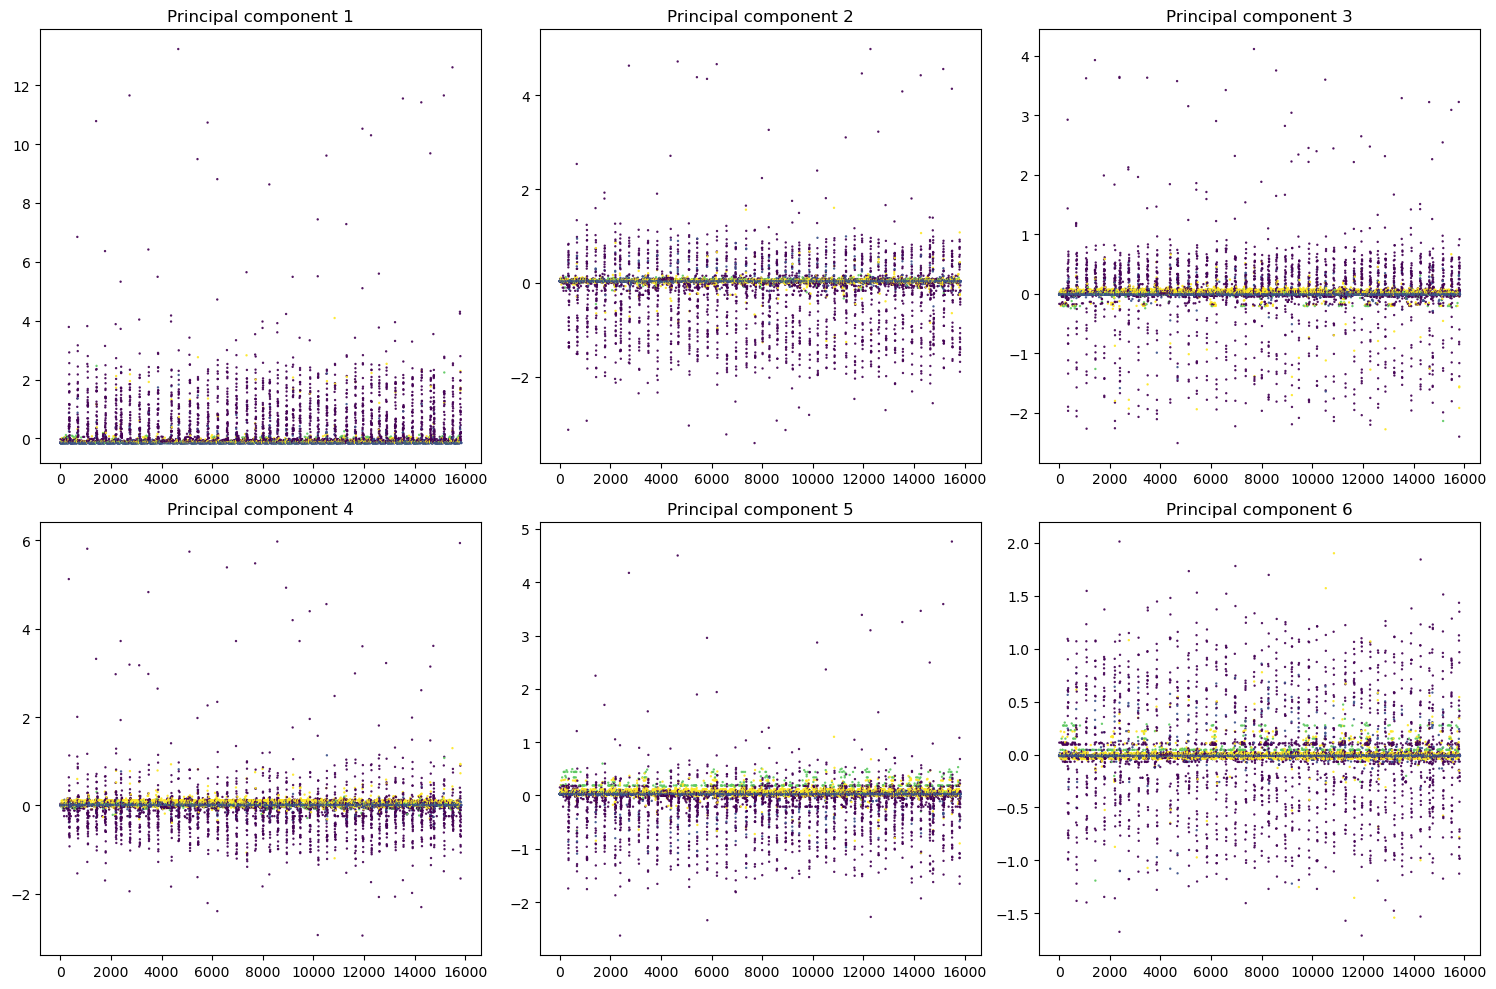

In [15]:
i = 3
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_pca[:, 0], X_pca[:, 1],  s = 1, c = X_se_clusters[i], alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.subplot(132)

plt.scatter(X_pca[:, 0], X_pca[:, 2],  s = 1, c = X_se_clusters[i], alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 3')

plt.subplot(133)
plt.scatter(X_pca[:, 1], X_pca[:, 2],  s = 1, c = X_se_clusters[i], alpha = 0.5)
plt.colorbar()
plt.xlabel('Principal component 2')
plt.ylabel('Principal component 3')

plt.tight_layout()

plt.show()

fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.scatter(np.arange(np.shape(X_pca)[0]), X_pca[:, i-1], s = 0.5, alpha = 0.9, c = X_se_clusters[0])
    plt.title('Principal component ' + str(i))
plt.tight_layout()
plt.show()

In [16]:
plt.figure(figsize = (10, 10))



print((np.array(Y['time'])//0.02).astype(int))

plt.scatter(Y['time'], Y['channel'], c = X_se_clusters[0][(np.array(Y['time'])//0.02).astype(int)], s = 0.5, alpha = 0.5)
#plt.scatter(Y_synchronized['frameno'], Y_synchronized['channel'], 1, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Channels')

t_start = 200
dt = 50
#plt.xlim((t_start, t + dt))
plt.ylim((0, 250))

[    0     2     3 ... 29999 30000 30000]


IndexError: index 15837 is out of bounds for axis 0 with size 15836

<Figure size 1000x1000 with 0 Axes>

## get mean number of firing neurons per state

In [ ]:
print(np.shape(X_se_clusters))
for i in range(n_clusters):
    for bin in range(np.shape(X_se_clusters)[1]):
        if X_se_clusters

SyntaxError: expected ':' (2265580108.py, line 4)

## build transition tables

# tsne

In [ ]:
X_tsne = list()
perplexities = np.arange(500, 3000, 500)

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(perplexity = perplexity)
    X_tsne.append(tsne.fit_transform(X_trimmed_both))

MemoryError: Unable to allocate 1.34 GiB for an array with shape (180017986,) and data type float64

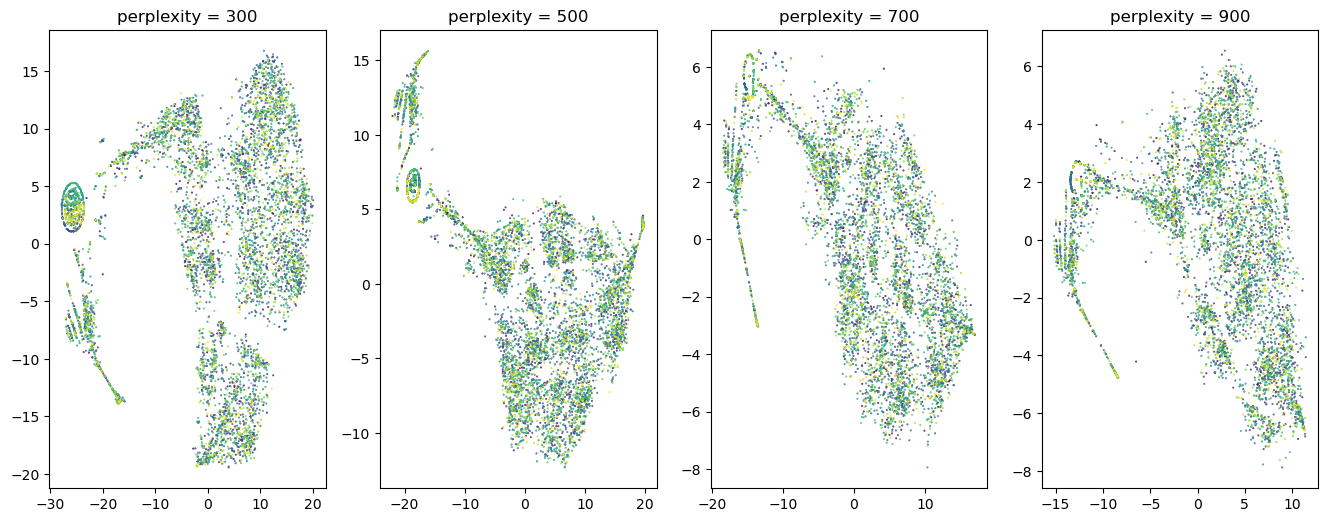

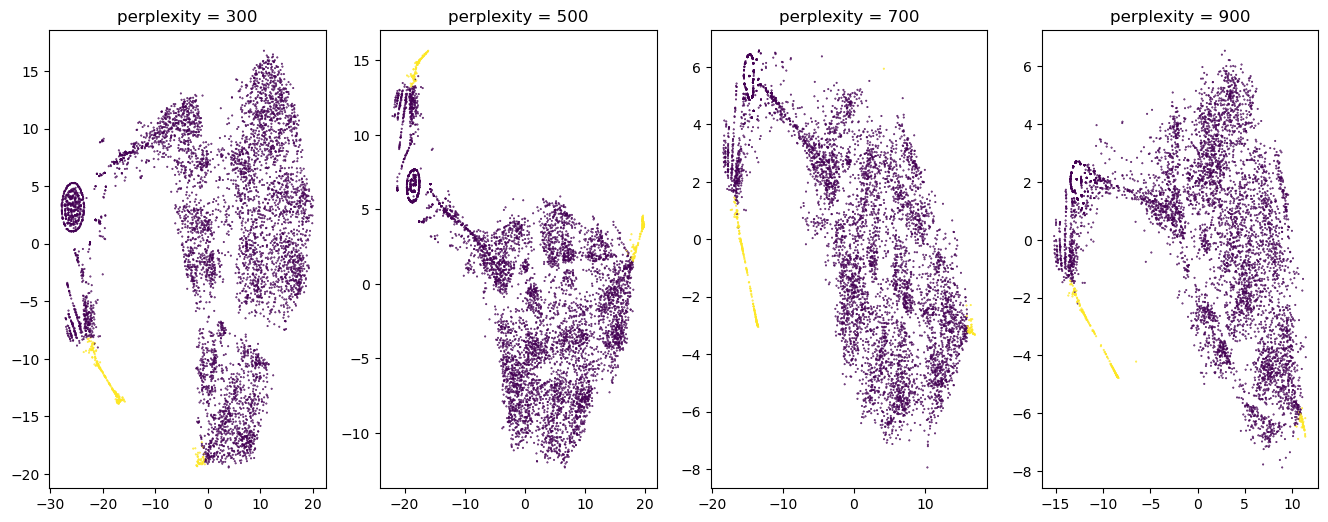

In [ ]:
fig = plt.figure(figsize = (20, 20))
for i, perplexity in enumerate(perplexities):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_tsne[i][:, 0], X_tsne[i][:, 1], s = 0.2, c = (t))
    plt.title('perplexity = ' + str(perplexity))

plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (20, 20))
for i, perplexity in enumerate(perplexities):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_tsne[i][:, 0], X_tsne[i][:, 1], s = 0.2, c = (X_pca[:, 1] > 2))
    plt.title('perplexity = ' + str(perplexity))

plt.tight_layout()

In [ ]:
X_tsne = list()
perplexities = np.arange(1000, 3000, 500)

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(perplexity = perplexity)
    X_tsne.append(tsne.fit_transform(X_pca))

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize = (20, 20))
for i, perplexity in enumerate(perplexities):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_tsne[i][:, 0], X_tsne[i][:, 1], s = 0.2, c = (t))
    plt.title('perplexity = ' + str(perplexity))

plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (20, 20))
for i, perplexity in enumerate(perplexities):
    plt.subplot(4, 6, i+1)
    plt.scatter(X_tsne[i][:, 0], X_tsne[i][:, 1], s = 0.2, c = (X_pca[:, 1] > 0))
    plt.title('perplexity = ' + str(perplexity))

plt.tight_layout()

NameError: name 'plt' is not defined

# Isomap

In [26]:
X_isomap = list()
neighbors = np.arange(10, 500, 150)
for i, neighbors in enumerate(neighbors):
    isomap = Isomap(n_neighbors= neighbors)
    X_isomap.append(isomap.fit_transform(X_trimmed_both))

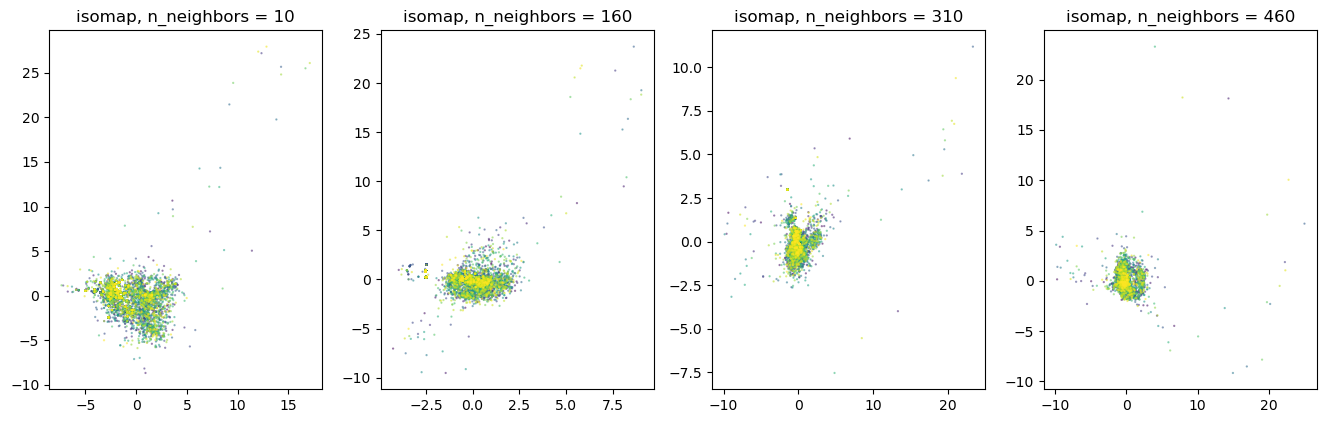

In [28]:
neighbors = np.arange(10, 500, 150)

plt.figure(figsize = (20, 20))
for i, neighbors in enumerate(neighbors):
    plt.subplot(5, 6, i+1)
    plt.scatter(X_isomap[i][:, 0], X_isomap[i][:, 1], s = 0.4, alpha=0.5, c = np.arange(np.shape(X_isomap[i])[0]))
    plt.title('isomap, n_neighbors = ' + str(neighbors))

plt.tight_layout()
plt.show()


In [38]:
X_umap = list()
neighbors = np.arange(10, 300, 40)
for i, neighbor in enumerate(neighbors):
    map = UMAP(n_neighbors= neighbor, min_dist = 0.5)
    X_umap.append(map.fit_transform(X_trimmed_both))

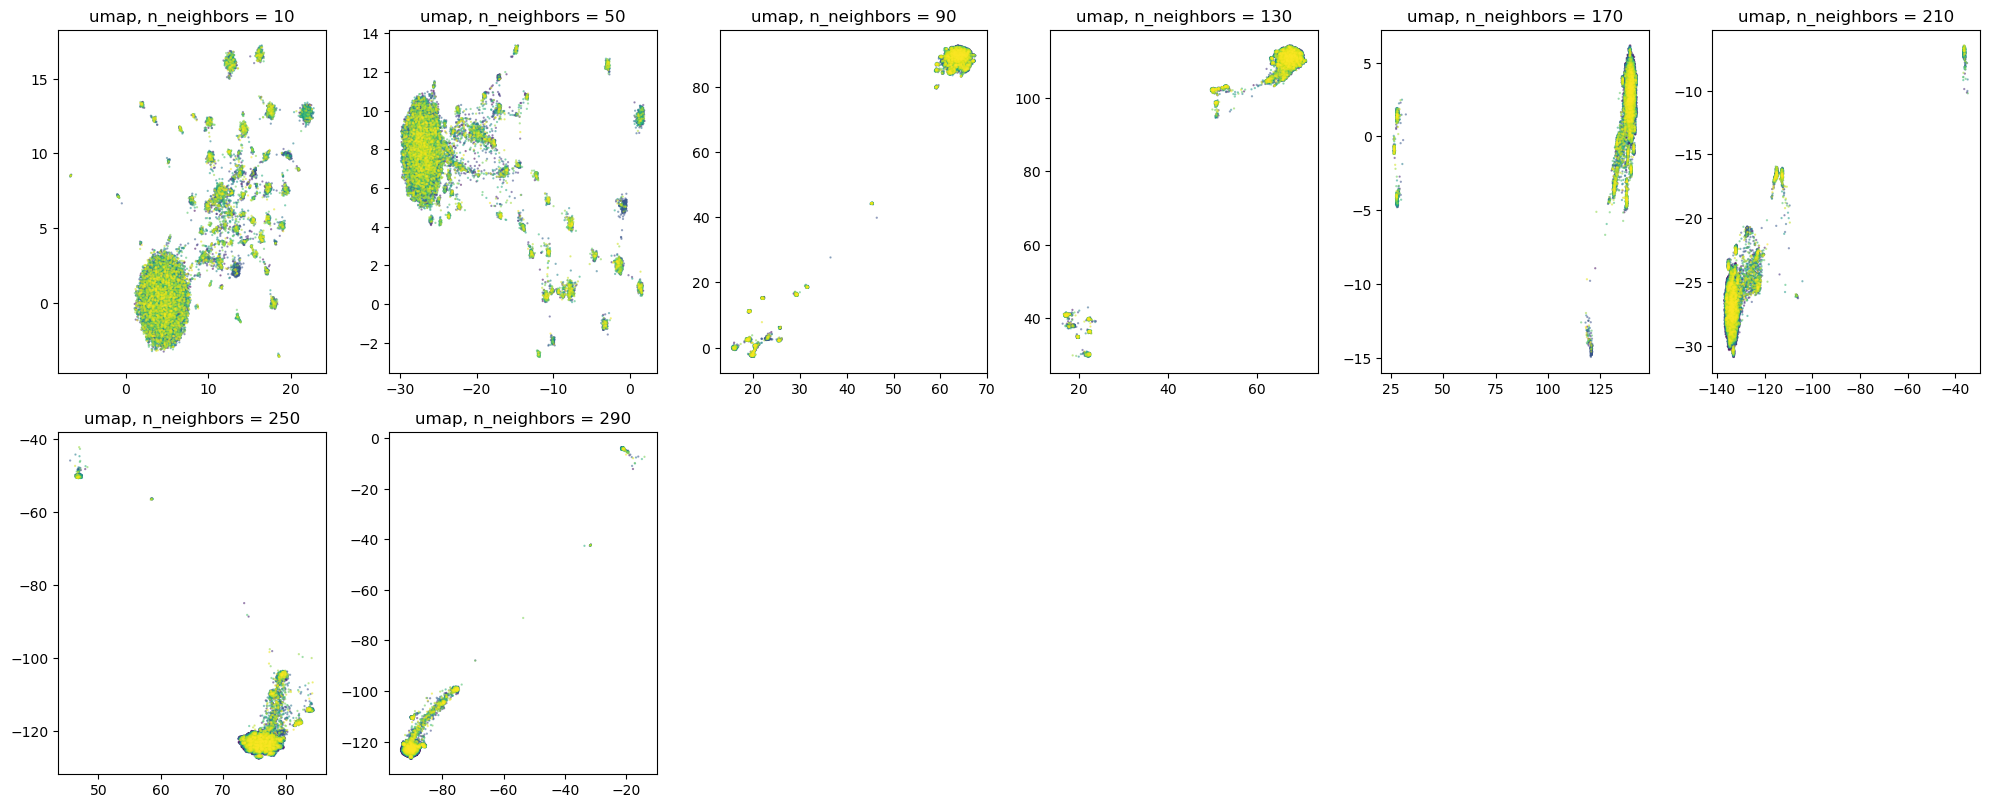

In [40]:
plt.figure(figsize = (20, 20))
neighbors = np.arange(10, 300, 40)


for i, neighbor in enumerate(neighbors):
    plt.subplot(5, 6, i+1)
    plt.scatter(X_umap[i][:, 0], X_umap[i][:, 1], s = 0.4, alpha=0.5, c = np.arange(np.shape(X_umap[i])[0]))
    plt.title('umap, n_neighbors = ' + str(neighbor))

plt.tight_layout()
plt.show()

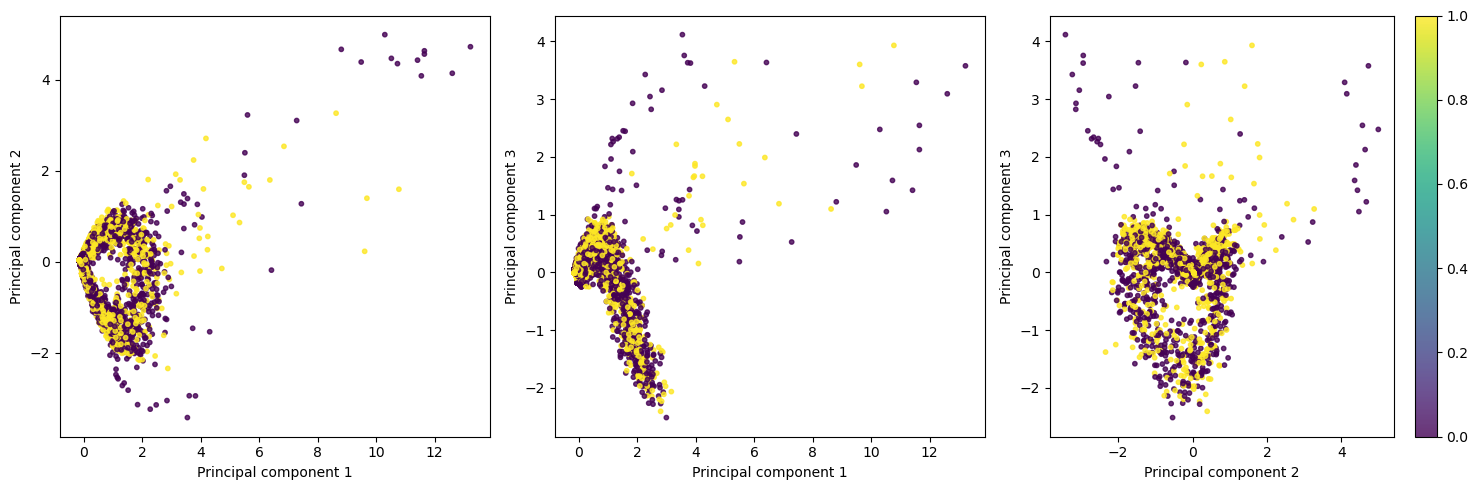

NameError: name 'X_se_clusters' is not defined

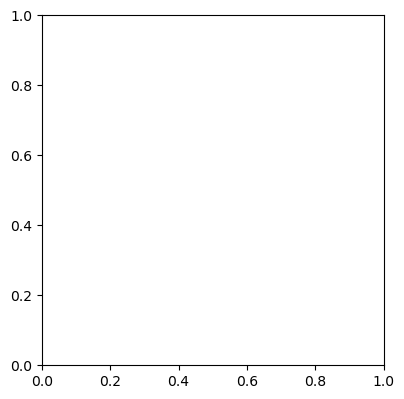

In [49]:
i = 2
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_pca[:, 0], X_pca[:, 1],  s = 10, c = X_umap[i][:, 0] < -20, alpha = 0.8)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.subplot(132)

plt.scatter(X_pca[:, 0], X_pca[:, 2],  s = 10, c = X_umap[i][:, 0] < -20, alpha = 0.8)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 3')

plt.subplot(133)
plt.scatter(X_pca[:, 1], X_pca[:, 2],  s = 10, c = X_umap[i][:, 0] < -20, alpha = 0.8)
plt.colorbar()
plt.xlabel('Principal component 2')
plt.ylabel('Principal component 3')

plt.tight_layout()

plt.show()

fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.scatter(np.arange(np.shape(X_pca)[0]), X_pca[:, i-1], s = 0.5, alpha = 0.9, c = X_se_clusters[0])
    plt.title('Principal component ' + str(i))
plt.tight_layout()
plt.show()